# PhosphoSite Data Formatting

This file takes data regarding kinase-protein interactions from the PhosphoSite database and converts the data into the .gmt format. The data was retrieved from the PhosphoSite database on Wed, Jun 14 2017 12:10:56. This data will be added to enhance the KEA2 database and will be suitably formatted for use by ENRICHR and X2K.

## Import packages necessary for following program

In [ ]:
%run /home/maayanlab/Projects/Scripts/init.ipy
%run /home/maayanlab/Projects/Scripts/Scripts.py

## Create a dataframe from a file containing PhosphoSite data

In [ ]:
#Define colnames (present in original dataset) for dataframe
colnames = ['Gene', 'kinase', 'Kin_Acc_ID', 'Kin_organism', 
            'substrate', 'sub_gene_id', 'sub_Acc_ID', 'sub_gene',
           'Sub_organism', 'sub_mod_rsd', 'SITE_GRP_ID',
            'SITE_+/-7_AA', 'DOMAIN', 'IN_VIVO_RXN', 'IN_VITRO_RXN','CST_CAT']

#read data from excel file into dataframe 'phospho_df'
site_df = pd.read_excel('~/Desktop/Kinase_Substrate_Dataset.xlsm', 
                           header = None, names = colnames)

#View dataframe
site_df.head()

## Filter by columns necessary for .GMT file format

In [ ]:
#Create dataframe 'df' with columns pertaining to kinase accession id,
#kinase organism, and substrate accession id
df = site_df[['Kin_Acc_ID', 'Kin_organism', 'sub_Acc_ID']]

#View dataframe
df.head()

## Filter dataframe by Organism
Ensures that kinase organism matches substrate organism, and subsets data pertaining only to mouse and human samples.

In [ ]:
# Check that kinase and substrate are of same organism
indices = [index for index, rowData in site_df.iterrows() 
           if rowData['Kin_organism'] == rowData['Sub_organism'] 
           and rowData['Kin_organism'] in ['human', 'mouse']]

# Filter the dataframe by organism
site_df_filtered = df.loc[indices]

# Replace 'human' and 'mouse' with 'Homo sapiens' and 'Mus musculus' for 'Kin_organism' column
site_df_filtered.Kin_organism.replace(['human', 'mouse'], ['Homo sapiens', 'Mus musculus'], inplace=True)

#View dataframe
site_df_filtered

## Convert UniProt IDs to Gene Symbols
For uniprot ids which yielded no gene symbol using the Scripts.py function, gene symbols were taken from the 'substrates' column of the original datafrane.

In [ ]:
#Use uniprot_to_symbol function from Scripts.py to convert
site_df_filtered['Kinases'] = Scripts.uniprot_to_symbol(site_df_filtered['Kin_Acc_ID'].tolist())

#Use uniprot_to_symbol function from Scripts.py to convert
site_df_filtered['Substrates'] = Scripts.uniprot_to_symbol(site_df_filtered['sub_Acc_ID'].tolist())

for index, kinase in site_df_filtered.Kinases.iteritems():
    if kinase == None:
        site_df_filtered.Kinases[index] = site_df.kinase[index]
        
for index, substrate in site_df_filtered.Substrates.iteritems():
    if substrate == None:
        site_df_filtered.Substrates[index] = site_df.substrate[index]
        
#View Dataframe
site_df_filtered.head(100)

## Combine 'Kinase' and 'Organism' Column and Create new Dataframe

In [ ]:
# Combine 'kinases' and 'species' into one column 'kinase_organism'
site_df_filtered['kinase_organism'] = ['_'.join([kinase, species]) for kinase, species in site_df_filtered[['Kinases', 'Kin_organism']].as_matrix()]

#View dataframe
site_df_filtered.head()

In [ ]:
#Create new dataframe 'PhosphoS_df' without accession ids for kinases/proteins
PhosphoS_df = site_df_filtered[['Substrates', 'kinase_organism']]

#drop duplicate rows in the dataframe
PhosphoS_df.drop_duplicates(inplace = True)

#View dataframe
PhosphoS_df.head()

## Set Index to 'Kinase_Organism' and Aggregate Kinase Targets

In [ ]:
#Set index to 'kinase_organism'
PhosphoS_df.set_index('kinase_organism')

#Group kinases in dataframe 'kin'
#Aggregate data in 'kin' according to kinase groups
kin = PhosphoS_df.groupby('kinase_organism').agg(lambda x: tuple(x))

#Create a new column 'PhosphoSite' as description of data
kin.insert(0, 'Description', 'PhosphoSite')

#Visualize Data
kin.head()

# Exploratory Data Analysis

## Calculate Number of Protein targets for each kinase
Create a new column with the number of substrates related to each kinase, and sort the dataframe by this column.

In [93]:
# Create column representing counts of protein targets per kinase
kin['kinase_substrate_num'] = [len(lst) for kinase, lst in kin['Substrates'].iteritems()]

# Sort kinases from max to min according to number of protein targets each has
kin.sort_values(by = ['kinase_substrate_num'], ascending= False, inplace=True)

# View dataframe
kin.head()

,Description,Substrates,kinase_substrate_num
kinase_organism,,,
PRKACA_Homo sapiens,PhosphoSite,"(GLI1, CUX1, HIF1A, VASP, RAP1B, CDK16, NOS3, ...",291
CDK2_Homo sapiens,PhosphoSite,"(NR1I2, SNAPIN, RAD9A, PELP1, ZYX, MCL1, RBL2,...",275
CDK1_Homo sapiens,PhosphoSite,"(MDM4, TOP2A, RAD9A, RANBP2, WEE1, MCL1, NUMA1...",262
CSNK2A1_Homo sapiens,PhosphoSite,"(DDX58, PAK1, DDIT3, MME, PTEN, RPS6KA5, PPP1R...",227
SRC_Homo sapiens,PhosphoSite,"(CASP8 iso4, PTEN, GJA1, SPTAN1, GAPDH, FLT4, ...",213


## Create Histogram to display distribution of number of targets per kinase

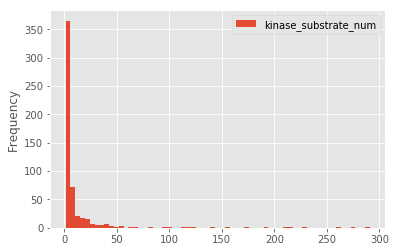

In [97]:
# Create histogram displaying the distribution of the number
#targets per kinase
kin.plot.hist(by = 'kinase_substrate_num', bins = 63)

#Show histogram
plt.show()

# Creation of Final .GMT File

## Create Dictionary of Tab-Separated Rows of the Dataframe

In [ ]:
#Reset index of the dataframe
kin.reset_index(inplace = True)

#create column 'acc_merged' in which all 'acc' elements are joined by a \t symbol
kin['substrates_merged'] = ['\t'.join(x) for x in kin['Substrates']]

#drop the now-unneccesary column 'Substrates'
kin.drop('Substrates', axis=1, inplace = True)

#also drop the data-exploratory column 'kinase_substrate_num'
kin.drop('kinase_substrate_num', axis=1, inplace = True)

#Create dictionary 'PhosphoSite' with index numbers as keys
PhosphoSite_num = dict([(key, '') for key in kin.index])

# loop through rows with iterrows()
for index, rowData in kin.iterrows():
    line = ('\t'.join(rowData))
    PhosphoSite_num[index] = line

## Write Info from Dictionary into a .GMT file

In [ ]:
#Transfer tab-separated info into a new txt file
with open('PhosphoSite.gmt', 'w') as openfile:
    for index in PhosphoSite_num:
        openfile.write(str(PhosphoSite_num[index]) + '\n')

## Test: Reading in the Newly-Created . GMT File

In [ ]:
df2 = pd.read_table('PhosphoSite.gmt', delimiter = '\t', names = ['']*141)
df2 = df2.replace(np.nan, '', regex=True)
df2.rename(columns = {'': 'kinase'}, inplace = True)
df2.rename(columns = {'.1': 'Description'}, inplace = True)

colnames = dict([(key, 'Substrate') for key in df2.columns[2:]])
df2.rename(columns= colnames, inplace = True)
df2